In [2]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import time
from pandas import ExcelWriter
from pandas import ExcelFile

Function to proses dataset

In [3]:
def preprocessing_data(filename1, filename2):
    start_time = time.time()
    df = pd.read_csv(filename1, delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])

    dataset_train = df
    training_set = dataset_train.iloc[:, 1:2].values
    training_set_scaled = training_set
    X_train = []
    y_train = []
    for i in range(32, len(training_set)):
        X_train.append(training_set_scaled[i-32, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train, y_train = X_train.reshape(-1, 1), y_train.reshape(-1, 1)

    dataset_test = pd.read_csv(filename2, delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
    real_price = dataset_test.iloc[:, 1:2].values
    dataset_total = pd.concat((dataset_train['Price'], dataset_test['Price']), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(dataset_test)- 32:].values
    inputs = inputs.reshape(-1,1)
    X_test = []
    for i in range(32, 64):
        X_test.append(inputs[i - 32, 0])
    X_test = np.array(X_test)
    X_test = X_test.reshape(-1, 1)

    total_time = time.time() - start_time
    return X_train, y_train, X_test, real_price, dataset_total, training_set, total_time

Function to predict with KNN

In [4]:
def KNN_Prediction(X_train, y_train, X_test, real_price, dataset_total, training_set, total_time):
    start_time = time.time()
    X_train, y_train = X_train.reshape(-1, 1), y_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    params = {'n_neighbors':[2,3,5,7,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=3)
    model.fit(X_train,y_train)
    training_set_scaled = training_set
    knn_prediction = model.predict(X_test)
    rms=np.sqrt(np.mean(np.power((np.array(real_price)-np.array(knn_prediction)),2)))
    data_total = dataset_total.values
    data_total = data_total.reshape(-1,1)
    predicted_price = knn_prediction
    total_time = total_time + time.time() - start_time

    return predicted_price, rms, total_time

Function to predict with SVM

In [5]:
def SVM_Prediction(X_train, y_train, X_test, real_price, dataset_total, training_set, total_time):
    start_time = time.time()
    X_train, y_train = X_train.reshape(-1, 1), y_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    svr_rbf = SVR(kernel='rbf', C=1e2, gamma=0.00001)
    svr_rbf.fit(X_train, y_train)
    svm_prediction = svr_rbf.predict(X_test)
    svm_prediction = svm_prediction.reshape(-1, 1)
    rms=np.sqrt(np.mean(np.power((np.array(real_price)-np.array(svm_prediction)),2)))
    data_total = dataset_total.values
    data_total = data_total.reshape(-1,1)
    predicted_price = svm_prediction
    total_time = total_time + time.time() - start_time

    return predicted_price, rms, total_time

Function to predict with LSTM

In [6]:
def LSTM_Prediction(filename1, filename2):
    start_time = time.time()
    df = pd.read_csv(filename1, delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
    data = df

    dataset_train = data
    training_set = dataset_train.iloc[:, 1:2].values

    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    X_train = []
    y_train = []
    for i in range(32, len(training_set)):
        X_train.append(training_set_scaled[i-32:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Initialising the RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 70, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 70, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 50, activation='sigmoid'))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs = 10, batch_size = 30)

    dataset_test = pd.read_csv(filename2, delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
    real_price = dataset_test.iloc[:, 1:2].values

    dataset_total = pd.concat((dataset_train['Price'], dataset_test['Price']), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(dataset_test)- 32:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)

    X_test = []
    for i in range(32, 64):
        X_test.append(inputs[i - 32:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_price = regressor.predict(X_test)
    predicted_price = sc.inverse_transform(predicted_price)
    data_total = dataset_total.values
    data_total = data_total.reshape(-1,1)
    rms=np.sqrt(np.mean(np.power((np.array(predicted_price)-np.array(real_price)),2)))
    total_time = time.time() - start_time

    return predicted_price, rms, real_price, total_time

Function to plot the graph

In [7]:
def Plot_Graph(data_total, predicted_price1, predicted_price2, predicted_price3, label_name):
    plt.plot(predicted_price1, color = 'blue', label = 'Predicted KNN '+ label_name)
    plt.plot(predicted_price2, color = 'green', label = 'Predicted SVM '+ label_name)
    plt.plot(predicted_price3, color = 'yellow', label = 'Predicted LSTM '+ label_name)
    plt.plot(data_total, color = 'red', label = 'Real ' + label_name)
    plt.title(label_name + ' Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(label_name + ' Price')
    plt.legend()
    plt.show()

Function to show the volatility

In [8]:
def Volatility(filename1, filename2, filename3, filename4):
    df1 = pd.read_csv(filename1, delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
    data1 = df1.sort_index(ascending=False, axis=0)
    df2 = pd.read_csv(filename2, delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
    data2 = df2.sort_index(ascending=False, axis=0)
    df3 = pd.read_csv(filename3, delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
    data3 = df3.sort_index(ascending=False, axis=0)
    df4 = pd.read_csv(filename4, delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
    data4 = df4.sort_index(ascending=False, axis=0)
    new_data = pd.DataFrame(index=range(0, 365),columns=['Change 1', 'Change 2', 'Change 3'])
    data_snp = pd.DataFrame(index=range(0, 250),columns=['Change 4'])
    for i in range(0,365):
        new_data['Change 1'][i] = float(data1['Change'][len(data1) - 365 + i-1])
        new_data['Change 2'][i] = float(data2['Change'][len(data2) - 365 + i-1])
        new_data['Change 3'][i] = float(data3['Change'][len(data3) - 365 + i-1])

    for i in range(0, 250):
        data_snp['Change 4'][i] = float(data4['Change'][i])

    bitcoin = np.array(new_data['Change 1'])
    etherum = np.array(new_data['Change 2'])
    xrp = np.array(new_data['Change 3'])
    snp500 = np.array(data_snp['Change 4'])
    std_bitcoin = np.std(bitcoin)*np.sqrt(len(bitcoin))
    std_etherum = np.std(etherum)*np.sqrt(len(etherum))
    std_xrp = np.std(xrp)*np.sqrt(len(xrp))
    std_snp500 = np.std(snp500)*np.sqrt(len(snp500))

    return std_bitcoin, std_etherum, std_xrp, std_snp500

Function to show RMSE of each prediction

In [9]:
def Comparison_Data(filename, data_actual, predicted_price1, predicted_price2, predicted_price3, label_name):
    df = pd.read_csv(filename, delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
    data_comparison = pd.DataFrame(index=range(0,32),columns=['Date', 'Actual Price '+label_name, 'Price KNN', 'RMSE KNN', 'Price SVM', 'RMSE SVM', 'Price LSTM', 'RMSE LSTM'])
    predicted_price1, predicted_price2, predicted_price3, data_actual = predicted_price1.ravel(), predicted_price2.ravel(), predicted_price3.ravel(), data_actual.ravel()
    for i in range(0, len(data_comparison)):
        data_comparison['Date'][i] = df['Date'][i]
        data_comparison['Actual Price '+label_name][i] = data_actual[i]
        data_comparison['Price KNN'][i] = predicted_price1[i]
        data_comparison['RMSE KNN'][i] = np.sqrt(np.mean(np.power((np.array(predicted_price1[i])-np.array(data_actual[i])),2)))
        data_comparison['Price SVM'][i] = predicted_price2[i]
        data_comparison['RMSE SVM'][i] = np.sqrt(np.mean(np.power((np.array(predicted_price2[i])-np.array(data_actual[i])),2)))
        data_comparison['Price LSTM'][i] = predicted_price3[i]
        data_comparison['RMSE LSTM'][i] = np.sqrt(np.mean(np.power((np.array(predicted_price3[i])-np.array(data_actual[i])),2)))
    data_comparison.to_excel('Data Comparison '+label_name+'.xlsx', index=False)
    return data_comparison

Import all dataset from github

In [11]:
!wget -O Bitcoin_Historical_Data_Test.csv https://raw.githubusercontent.com/alazkiyai09/financial_eng/master/Bitcoin%20Historical%20Data%20Test.csv
!wget -O Bitcoin_Historical_Data_Train.csv https://raw.githubusercontent.com/alazkiyai09/financial_eng/master/Bitcoin%20Historical%20Data%20Train.csv
!wget -O Etherum_Historical_Data_Train.csv https://raw.githubusercontent.com/alazkiyai09/financial_eng/master/Ethereum%20Historical%20Data%20Train.csv
!wget -O Etherum_Historical_Data_Test.csv https://raw.githubusercontent.com/alazkiyai09/financial_eng/master/Etherum%20Historical%20Data%20Test.csv
!wget -O XRP_Historical_Data_Test.csv https://raw.githubusercontent.com/alazkiyai09/financial_eng/master/XRP%20Historical%20Data%20Test.csv
!wget -O XRP_Historical_Data_Train.csv https://raw.githubusercontent.com/alazkiyai09/financial_eng/master/XRP%20Historical%20Data%20Train.csv
!wget -O SnP500_Historical_Data.csv https://raw.githubusercontent.com/alazkiyai09/financial_eng/master/SnP500%20Historical%20Data%20Train.csv

--2020-08-25 06:51:08--  https://raw.githubusercontent.com/alazkiyai09/financial_eng/master/Bitcoin%20Historical%20Data%20Test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1460 (1.4K) [text/plain]
Saving to: ‘Bitcoin_Historical_Data_Test.csv’

Bitcoin_Historical_ 100%[===================>]   1.43K  --.-KB/s    in 0s      

2020-08-25 06:51:08 (19.5 MB/s) - ‘Bitcoin_Historical_Data_Test.csv’ saved [1460/1460]

--2020-08-25 06:51:08--  https://raw.githubusercontent.com/alazkiyai09/financial_eng/master/Bitcoin%20Historical%20Data%20Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
H

Data Train of Bitcoin

In [12]:
df = pd.read_csv("Bitcoin_Historical_Data_Train.csv", delimiter= ';', names = ['Date', 'Price','Open','High','Low','Change'])
df.head(5)

,Date,Price,Open,High,Low,Change
0,01/01/2014,815.9,805.9,829.9,771.0,1.24
1,02/01/2014,856.9,815.9,886.2,810.5,5.02
2,03/01/2014,884.3,856.9,888.2,839.4,3.19
3,04/01/2014,924.7,884.3,932.2,848.3,4.57
4,05/01/2014,1014.7,924.7,1029.9,911.4,9.74


Data Test of Bitcoin

In [13]:
df = pd.read_csv("Bitcoin_Historical_Data_Test.csv", delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
df.head(5)

,Date,Price,Open,High,Low,Change
0,10/01/2019,8302.7,8285.0,8486.2,8187.9,0.22
1,10/02/2019,8364.1,8302.7,8374.0,8167.7,0.74
2,10/03/2019,8226.9,8363.6,8391.7,8090.1,-1.64
3,10/04/2019,8148.1,8227.6,8233.6,8041.4,-0.96
4,10/05/2019,8127.3,8148.0,8185.1,8030.6,-0.25


Data Train of Etherum

In [14]:
df = pd.read_csv("Etherum_Historical_Data_Train.csv", delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
df.head(5)

,Date,Price,Open,High,Low,Change
0,10/03/2016,11.75,11.20,11.85,11.07,4.91
1,11/03/2016,11.95,11.75,11.95,11.75,1.70
2,12/03/2016,12.92,11.95,13.45,11.95,8.12
3,13/03/2016,15.07,12.92,15.07,12.92,16.64
4,14/03/2016,12.50,15.07,15.07,11.40,-17.05


Data Test of Etherum

In [15]:
df = pd.read_csv("Etherum_Historical_Data_Test.csv", delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
df.head(5)

,Date,Price,Open,High,Low,Change
0,10/01/2019,175.78,180.36,184.95,174.03,-2.54
1,10/02/2019,180.27,175.78,180.84,173.97,2.56
2,10/03/2019,174.54,180.26,180.57,170.65,-3.18
3,10/04/2019,175.65,174.58,178.43,171.33,0.64
4,10/05/2019,176.43,175.65,176.63,172.39,0.44


Data Train of XRP

In [16]:
df = pd.read_csv("XRP_Historical_Data_Train.csv", delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
df.head(5)

,Date,Price,Open,High,Low,Change
0,01/02/2015,0.01352,0.01499,0.01499,0.01351,-9.81
1,02/02/2015,0.01327,0.01500,0.01500,0.01327,-1.85
2,03/02/2015,0.01480,0.01327,0.01500,0.01327,11.53
3,04/02/2015,0.01400,0.01480,0.01480,0.01400,-5.41
4,05/02/2015,0.01573,0.01400,0.01573,0.01300,12.36


Data Test of XRP

In [17]:
df = pd.read_csv("XRP_Historical_Data_Test.csv", delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
df.head(5)

,Date,Price,Open,High,Low,Change
0,10/01/2019,0.24805,0.25643,0.26061,0.24512,-3.27
1,10/02/2019,0.25279,0.24806,0.25453,0.24455,1.91
2,10/03/2019,0.24683,0.25275,0.25292,0.24225,-2.36
3,10/04/2019,0.25244,0.24681,0.25627,0.24493,2.27
4,10/05/2019,0.25318,0.25245,0.25625,0.24707,0.29


Historical Data of SnP500

In [18]:
df = pd.read_csv("SnP500_Historical_Data.csv", delimiter=';', names = ['Date', 'Price','Open','High','Low','Change'])
df.head(5)

,Date,Price,Open,High,Low,Change
0,09/04/2018,2896.72,2896.96,2900.18,2885.13,-0.17
1,09/05/2018,2888.60,2891.59,2894.21,2876.92,-0.28
2,09/06/2018,2878.05,2888.64,2892.05,2867.29,-0.37
3,09/07/2018,2871.68,2868.26,2883.81,2864.12,-0.22
4,09/10/2018,2877.13,2881.39,2886.93,2875.94,0.19


In [19]:
filename1 = 'Bitcoin_Historical_Data_Train.csv'
filename2 = 'Etherum_Historical_Data_Train.csv'
filename3 = 'XRP_Historical_Data_Train.csv'
filename4 = 'Bitcoin_Historical_Data_Test.csv'
filename5 = 'Etherum_Historical_Data_Test.csv'
filename6 = 'XRP_Historical_Data_Test.csv'
filename7 = 'SnP500_Historical_Data.csv'

Show the volatility of cryptocurrency

In [20]:
std_bitcoin, std_etherum, std_xrp, std_snp500 = Volatility(filename1, filename2, filename3, filename7)
print("STD Bitcoin:", std_bitcoin)
print("STD Etherum:", std_etherum)
print("STD XRP:", std_xrp)
print("STD S&P500:", std_snp500)

STD Bitcoin: 71.66592477390235
STD Etherum: 95.45143786311958
STD XRP: 97.70329351300128
STD S&P500: 16.513530403883962


In [21]:
rms1 = []
rms2 = []
rms3 = []
time1 = []
time2 = []
time3 = []

Bitcoin Price Prediction

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/10
68/68 [==============================] - 3s 49ms/step - loss: 0.0557
Epoch 2/10
68/68 [==============================] - 3s 48ms/step - loss: 0.0203
Epoch 3/10
68/68 [==============================] - 3s 48ms/step - loss: 0.0092
Epoch 4/10
68/68 [==============================] - 3s 49ms/step - loss: 0.0059
Epoch 5/10
68/68 [==============================] - 3s 49ms/step - loss: 0.0045
Epoch 6/10
68/68 [==============================] - 3s 49ms/step - loss: 0.0039
Epoch 7/10
68/68 [==============================] - 3s 49ms/step - loss: 0.0036
Epoch 8/10
68/68 [==============================] - 3s 50ms/step - loss: 0.0034
Epoch 9/10
68/68 [==============================] - 3s 49ms/step - loss: 0.0032
Epoch 10/10
68/68 [==============================] - 3s 48ms/step - loss: 0.0029


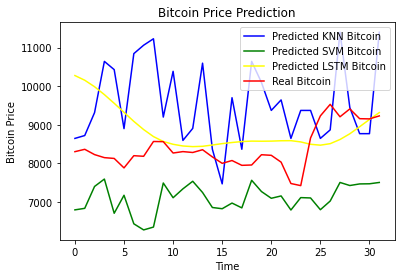

,Date,Actual Price Bitcoin,Price KNN,RMSE KNN,Price SVM,RMSE SVM,Price LSTM,RMSE LSTM
0,10/01/2019,8302.7,8646.7,344,6794.17,1508.53,10276.3,1973.57
1,10/02/2019,8364.1,8721.33,357.233,6833.67,1530.43,10154.8,1790.67
2,10/03/2019,8226.9,9315.23,1088.33,7400.96,825.945,9986.26,1759.36
3,10/04/2019,8148.1,10643.1,2495,7592.44,555.657,9781.76,1633.66
4,10/05/2019,8127.3,10429.8,2302.53,6706.04,1421.26,9556.94,1429.64
5,10/06/2019,7881.9,8900.37,1018.47,7172.52,709.384,9322.35,1440.45
6,10/07/2019,8198.6,10844.6,2646,6432.75,1765.85,9087.69,889.089
7,10/08/2019,8182.9,11062.6,2879.67,6274.37,1908.53,8875.59,692.693
8,10/09/2019,8566.7,11229.7,2662.97,6348.15,2218.55,8694.14,127.438
9,10/10/2019,8562.3,9199.8,637.5,7490.49,1071.81,8566.7,4.4002


In [22]:
np.random.seed(10)
predicted_price = []
X_train, y_train, X_test, real_price, dataset_total, training_set, total_time = preprocessing_data(filename1, filename4)
predicted_price1, temp2, temp1 = KNN_Prediction(X_train, y_train, X_test, real_price, dataset_total, training_set, total_time)
rms1.append(temp2)
time1.append(temp1)
predicted_price2, temp2, temp1 = SVM_Prediction(X_train, y_train, X_test, real_price, dataset_total, training_set, total_time)
rms2.append(temp2)
time2.append(temp1)
predicted_price3, temp2, data_actual, temp1 = LSTM_Prediction(filename1, filename4)
rms3.append(temp2)
time3.append(temp1)
Plot_Graph(data_actual, predicted_price1, predicted_price2, predicted_price3, "Bitcoin")
data_comparison = Comparison_Data(filename4, data_actual, predicted_price1, predicted_price2, predicted_price3, "Bitcoin")
data_comparison.head(10)

Etherum Price Prediction

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/10
1239/1239 [==============================] - 19s 15ms/step - loss: 0.0694
Epoch 2/10
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0399
Epoch 3/10
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0204
Epoch 4/10
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0089
Epoch 5/10
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0081
Epoch 6/10
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0058
Epoch 7/10
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0043
Epoch 8/10
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0046
Epoch 9/10
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0043
Epoch 10/10
1239/1239 [==============================] - 4s 3ms/step - loss: 0.0037


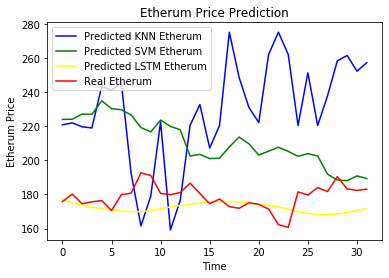

,Date,Actual Price Etherum,Price KNN,RMSE KNN,Price SVM,RMSE SVM,Price LSTM,RMSE LSTM
0,10/01/2019,175.78,220.848,45.0678,224.019,48.2388,176.991,1.21075
1,10/02/2019,180.27,221.964,41.6944,224.136,43.8658,175.098,5.17204
2,10/03/2019,174.54,219.701,45.1611,227.117,52.577,173.696,0.844382
3,10/04/2019,175.65,219,43.35,227.001,51.351,172.522,3.12766
4,10/05/2019,176.43,243.344,66.9144,234.929,58.4989,171.594,4.83576
5,10/06/2019,170.55,241.178,70.6278,230.337,59.787,170.919,0.368655
6,10/07/2019,179.87,245.576,65.7056,229.68,49.8102,170.227,9.64319
7,10/08/2019,180.78,192.24,11.46,226.619,45.8386,169.88,10.8999
8,10/09/2019,192.64,161.533,31.1067,219.24,26.5999,169.849,22.7914
9,10/10/2019,191.1,179.094,12.0056,216.732,25.6324,170.499,20.6013


In [ ]:
np.random.seed(10)
predicted_price = []
X_train, y_train, X_test, real_price, dataset_total, training_set, total_time = preprocessing_data(filename2, filename5)
predicted_price1, temp2, temp1 = KNN_Prediction(X_train, y_train, X_test, real_price, dataset_total, training_set, total_time)
rms1.append(temp2)
time1.append(temp1)
predicted_price2, temp2, temp1 = SVM_Prediction(X_train, y_train, X_test, real_price, dataset_total, training_set, total_time)
rms2.append(temp2)
time2.append(temp1)
predicted_price3, temp2, data_actual, temp1 = LSTM_Prediction(filename2, filename5)
rms3.append(temp2)
time3.append(temp1)
Plot_Graph(data_actual, predicted_price1, predicted_price2, predicted_price3, "Etherum")
data_comparison = Comparison_Data(filename5, data_actual, predicted_price1, predicted_price2, predicted_price3, "Etherum")
data_comparison.head(10)

XRP price Prediction

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/10
1642/1642 [==============================] - 21s 13ms/step - loss: 0.0770
Epoch 2/10
1642/1642 [==============================] - 5s 3ms/step - loss: 0.0450
Epoch 3/10
1642/1642 [==============================] - 5s 3ms/step - loss: 0.0156
Epoch 4/10
1642/1642 [==============================] - 5s 3ms/step - loss: 0.0074
Epoch 5/10
1642/1642 [==============================] - 5s 3ms/step - loss: 0.0044
Epoch 6/10
1642/1642 [==============================] - 5s 3ms/step - loss: 0.0045
Epoch 7/10
1642/1642 [==============================] - 5s 3ms/step - loss: 0.0032
Epoch 8/10
1642/1642 [==============================] - 5s 3ms/step - loss: 0.0023
Epoch 9/10
1642/1642 [==============================] - 5s 3ms/step - loss: 0.0020
Epoch 10/10
1642/1642 [==============================] - 5s 3ms/step - loss: 0.0017


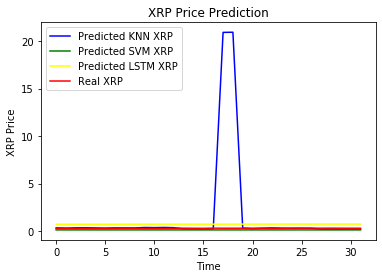

,Date,Actual Price XRP,Price KNN,RMSE KNN,Price SVM,RMSE SVM,Price LSTM,RMSE LSTM
0,10/01/2019,0.24805,0.327698,0.0796478,0.114799,0.133251,0.709567,0.461517
1,10/02/2019,0.25279,0.304886,0.0520956,0.114727,0.138063,0.709944,0.457154
2,10/03/2019,0.24683,0.328906,0.0820756,0.114805,0.132025,0.710303,0.463473
3,10/04/2019,0.25244,0.332891,0.0804511,0.114847,0.137593,0.710816,0.458376
4,10/05/2019,0.25318,0.321489,0.0683089,0.114915,0.138265,0.711455,0.458275
5,10/06/2019,0.25532,0.305301,0.0499811,0.114732,0.140588,0.712248,0.456928
6,10/07/2019,0.2758,0.32837,0.05257,0.114716,0.161084,0.712874,0.437074
7,10/08/2019,0.27753,0.323366,0.0458356,0.114669,0.162861,0.713611,0.436081
8,10/09/2019,0.28095,0.322794,0.0418444,0.114456,0.166494,0.714408,0.433458
9,10/10/2019,0.27033,0.36761,0.09728,0.114505,0.155825,0.71505,0.44472


In [ ]:
np.random.seed(11)
predicted_price = []
X_train, y_train, X_test, real_price, dataset_total, training_set, total_time = preprocessing_data(filename3, filename6)
predicted_price1, temp2, temp1 = KNN_Prediction(X_train, y_train, X_test, real_price, dataset_total, training_set, total_time)
rms1.append(temp2)
time1.append(temp1)
predicted_price2, temp2, temp1 = SVM_Prediction(X_train, y_train, X_test, real_price, dataset_total, training_set, total_time)
rms2.append(temp2)
time2.append(temp1)
predicted_price3, temp2, data_actual, temp1 = LSTM_Prediction(filename3, filename6)
rms3.append(temp2)
time3.append(temp1)
Plot_Graph(data_actual, predicted_price1, predicted_price2, predicted_price3, "XRP")
data_comparison = Comparison_Data(filename6,data_actual, predicted_price1, predicted_price2, predicted_price3, "XRP")
data_comparison.head(10)

Show the Total of Error

In [ ]:
new_data = pd.DataFrame(index=range(0, 3),columns=['Product', 'RMSE KNN', 'RMSE SVM', 'RMSE LSTM'])
new_data['Product'][0] = 'Bitcoin'
new_data['Product'][1] = 'Etherum'
new_data['Product'][2] = 'XRP'
new_data['RMSE KNN'] = rms1[:3]
new_data['RMSE SVM'] = rms2[:3]
new_data['RMSE LSTM'] = rms3[:3]
new_data.head(10)


,Product,RMSE KNN,RMSE SVM,RMSE LSTM
0,Bitcoin,1589.698304,1417.886603,843.515707
1,Etherum,60.471971,35.915581,10.410943
2,XRP,5.161496,0.167265,0.438643


Show Exectuion Time of Algorithm (In Second)

In [ ]:
new_data = pd.DataFrame(index=range(0, 3),columns=['Product', 'Execution Time of KNN', 'Execution Time of SVM', 'Execution Time of LSTM'])
new_data['Product'][0] = 'Bitcoin'
new_data['Product'][1] = 'Etherum'
new_data['Product'][2] = 'XRP'
new_data['Execution Time of KNN'] = time1[:3]
new_data['Execution Time of SVM'] = time2[:3]
new_data['Execution Time of LSTM'] = time3[:3]
new_data.head(10)

,Product,Execution Time of KNN,Execution Time of SVM,Execution Time of LSTM
0,Bitcoin,0.061323,0.337633,85.622919
1,Etherum,0.053054,0.131516,62.551328
2,XRP,0.056815,0.208110,73.891906
